Credit Card Fraud Detection (Isolation Forest + XGBoost)

1. Importing Libraries

Credit Card Fraud Detection (Isolation Forest + XGBoost)
1. Importing Libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For anomaly detection and ML
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# For handling imbalanced datasets
from imblearn.over_sampling import SMOTE

2.  Load dataset

In [31]:
df = pd.read_csv("creditcard.csv")
print("Shape:", df.shape)
print(df['Class'].value_counts())

Shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


3. EDA (peek at class imbalance)

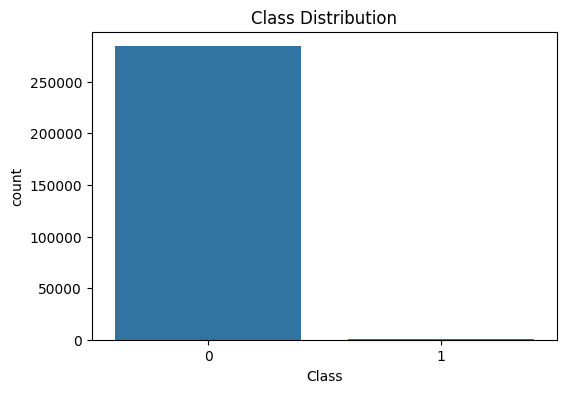

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

4. Data Preparation

In [33]:
# No missing values and features are numeric with PCA. Keep 'Time' and 'Amount'.
features = [col for col in df.columns if col not in ('Class')]
X = df[features]
y = df['Class']

# Optionally scale data
from sklearn.preprocessing import StandardScaler
X[['Time', 'Amount']] = StandardScaler().fit_transform(X[['Time', 'Amount']])

5. Train/Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

6. Handle Class Imbalance (SMOTE oversampling)

In [35]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Resampled class distribution:\n", pd.Series(y_train_res).value_counts())

Resampled class distribution:
 Class
0    213236
1    213236
Name: count, dtype: int64


7. Isolation Forest (Unsupervised Anomaly Detection)

In [36]:
iso = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso.fit(X_train_res)
y_pred_iso = iso.predict(X_test)
# Map predictions (-1=fraud, 1=not fraud) to (1=fraud, 0=not fraud)
y_pred_iso = np.where(y_pred_iso==-1, 1, 0)
print("\nIsolation Forest Results:\n")
print(classification_report(y_test, y_pred_iso))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_iso))


Isolation Forest Results:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.04      0.23      0.07       123

    accuracy                           0.99     71202
   macro avg       0.52      0.61      0.53     71202
weighted avg       1.00      0.99      0.99     71202

ROC-AUC: 0.6090940036146658


8. XGBoost Model (Supervised)

In [37]:
xgb = XGBClassifier(
    n_estimators=100, 
    max_depth=6, 
    learning_rate=0.1, 
    subsample=0.7,
    colsample_bytree=0.7,
    scale_pos_weight=len(y_train_res[y_train_res==0])/len(y_train_res[y_train_res==1]),
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]

print("\nXGBoost Results:\n")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))


XGBoost Results:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.34      0.85      0.49       123

    accuracy                           1.00     71202
   macro avg       0.67      0.92      0.74     71202
weighted avg       1.00      1.00      1.00     71202

ROC-AUC: 0.9809456259421413


9. Confusion Matrix and ROC Curve

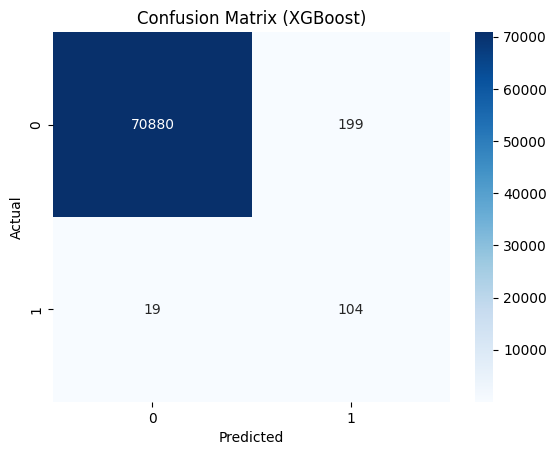

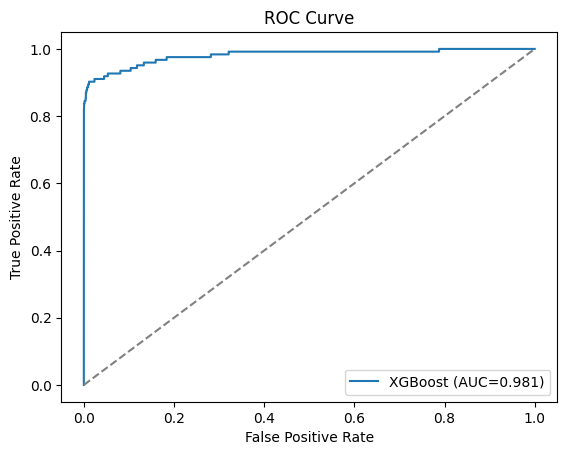

In [38]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr, tpr, label='XGBoost (AUC=%.3f)' % roc_auc_score(y_test, y_pred_proba_xgb))
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

10. Feature Importance (Optional)

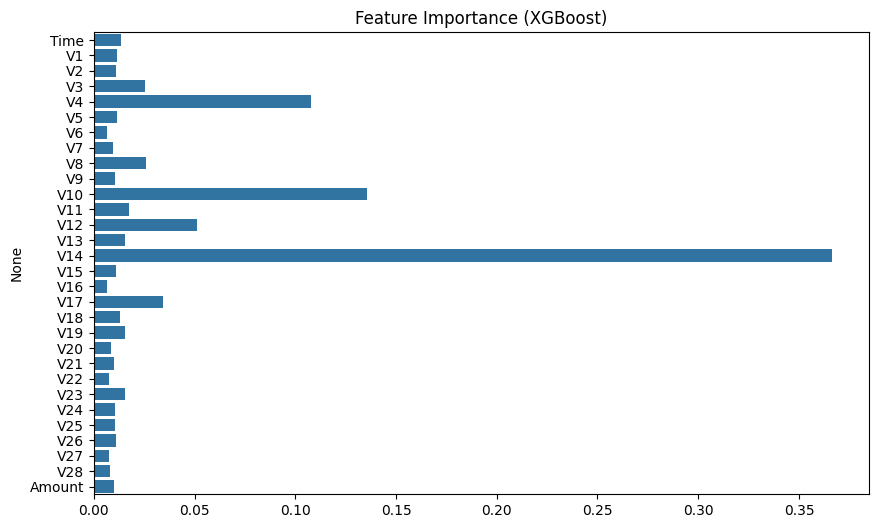

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(
    x=xgb.feature_importances_,
    y=X.columns
)
plt.title('Feature Importance (XGBoost)')
plt.show()

11.Saving Model and Scaler

In [ ]:
import joblib

# Save the trained XGBoost model and the scaler
joblib.dump(xgb, "xgb_fraud_model.pkl")

['xgb_fraud_model.pkl']

In [41]:
from sklearn.preprocessing import StandardScaler

In [42]:

# If you used StandardScaler for only 'Amount' and 'Time':
scaler = StandardScaler().fit(df[['Time', 'Amount']])
joblib.dump(scaler, "amount_time_scaler.pkl")

['amount_time_scaler.pkl']